In [1]:
import pandas as pd

In [ ]:
data = pd.read_csv("processed_30seconds.csv")
# Original DataFrame
print("Original DataFrame:")
print(data)

# Attempt the user's code (which triggers SettingWithCopyWarning and may not modify the original)
try:
    data[data['sex'].notna()]['sex'] = data[data['sex'].notna()]['sex'].apply(lambda x: 'm' if x.lower()[0] == 'm' else 'f')
except:
    pass  # Ignore any errors for demonstration



# Correct way using .loc to ensure modification of the original DataFrame
data.loc[data['sex'].notna(), 'sex'] = data.loc[data['sex'].notna(), 'sex'].apply(lambda x: 'm' if x.lower()[0] == 'm' else 'f')


(array([6365.,    0.,    0.,    0.,    0., 2873.,    0.,    0.,    0.,
        2469.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

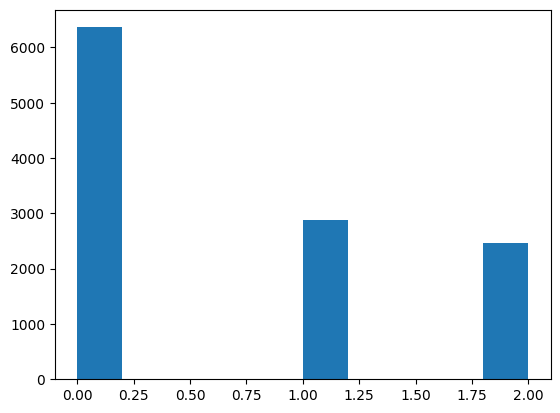

In [3]:
import matplotlib.pyplot as plt

plt.hist(data['MCL'])

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AutoProcessor, AutoModel
import torchaudio
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.utils import clip_grad_norm_
import audiomentations

# Step 1: Use the predefined data variable
print("Step 1: Using the predefined data variable...")
df = data
print(f"Dataframe with {len(df)} entries.")

# Step 1.5: Pre-training visualization of important factors
print("Step 1.5: Visualizing important factors pre-training...")

# Distribution plots
plt.figure(figsize=(4, 4))
sns.histplot(df['MCL'], kde=False)
plt.title('MCL Distribution')
plt.tight_layout()
plt.savefig('pre_distributions.png')
plt.close()
print("Pre-training distributions saved as 'pre_distributions.png'.")

# Step 2: Prepare data splits
print("Step 2: Preparing data splits...")
df_train_full = df[df['split'] == 'train'].reset_index(drop=True)
df_test = df[df['split'] == 'test'].reset_index(drop=True)

# Split train_full into train and val by ID
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(df_train_full, groups=df_train_full['ID']))
df_train = df_train_full.iloc[train_idx].reset_index(drop=True)
df_val = df_train_full.iloc[val_idx].reset_index(drop=True)
print(f"Train set: {len(df_train)} samples, Internal Val set: {len(df_val)} samples, Test set: {len(df_test)} samples.")

# Step 3: Define the Dataset class
class AudioDataset(Dataset):
    def __init__(self, df, processor, is_train=False):
        self.df = df
        self.processor = processor
        self.min_length = 16000  # Minimum length: 1 second at 16kHz to be safe
        self.is_train = is_train
        self.aug = audiomentations.Compose([
            audiomentations.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
            audiomentations.Gain(min_gain_db=-6, max_gain_db=6, p=0.5),
            audiomentations.PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
            audiomentations.TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
            audiomentations.Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
            audiomentations.PolarityInversion(p=0.5),
            audiomentations.LowPassFilter(min_cutoff_freq=150, max_cutoff_freq=2000, p=0.5),
            audiomentations.HighPassFilter(min_cutoff_freq=100, max_cutoff_freq=500, p=0.5),
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row['processed_path']
        
        # Load audio (handles wav/mp3)
        waveform, sr = torchaudio.load(audio_path)
        # Resample to 16kHz for wav2vec2
        resampler = torchaudio.transforms.Resample(sr, 16000)
        waveform = resampler(waveform)
        # Convert to mono if stereo
        waveform = waveform.mean(dim=0) if waveform.shape[0] > 1 else waveform.squeeze(0)
        
        # Clamp to [-1,1] in case of unnormalized audio
        waveform = torch.clamp(waveform, -1.0, 1.0)
        
        if self.is_train:
            # Apply audiomentations
            waveform_np = waveform.numpy()
            waveform_np = self.aug(waveform_np, sample_rate=16000)
            waveform = torch.from_numpy(waveform_np)
        
        # Add small noise to avoid issues with silent audio
        waveform += 1e-6 * torch.randn_like(waveform)
        
        # Pad short audio
        if waveform.numel() < self.min_length:
            padding = self.min_length - waveform.numel()
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        
        # Manual normalization with min std to prevent division by small numbers
        mean = waveform.mean()
        std = waveform.std()
        std = max(std, 1e-5)
        waveform = (waveform - mean) / std
        
        # Process audio without further normalization
        inputs = self.processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)
        
        # Label (0,1,2)
        label = torch.tensor(row['MCL'], dtype=torch.long)
        
        return inputs['input_values'].squeeze(0), label

# Step 4: Define the Model (Transformer-based with Wav2Vec2 for multi-class classification)
class MultiClassModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.audio_model = AutoModel.from_pretrained("facebook/wav2vec2-base")
        self.head = nn.Sequential(
            nn.Linear(self.audio_model.config.hidden_size, 512),
            nn.BatchNorm1d(512),  # BatchNorm to prevent overfitting
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 3)  # 3 classes
        )
        
    def forward(self, input_values):
        # Extract audio features (mean pool over sequence)
        audio_feats = self.audio_model(input_values).last_hidden_state.mean(dim=1)
        return self.head(audio_feats)

# Step 5: Setup processor, datasets, dataloaders
print("Step 5: Setting up processor, datasets, and dataloaders...")
processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base")
processor.feature_extractor.do_normalize = False  # We handle normalization manually
train_dataset = AudioDataset(df_train, processor, is_train=True)
val_dataset = AudioDataset(df_val, processor)
test_dataset = AudioDataset(df_test, processor)

# Dataloaders with reduced workers to prevent RAM overload
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)
print("Datasets and dataloaders ready.")

# Step 6: Setup model, optimizer, loss, device
print("Step 6: Setting up model, optimizer, and loss...")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MultiClassModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()  # Cross Entropy for multi-class
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
print(f"Model setup on {device}.")

# Step 7: Training loop (internal validation)
num_epochs = 20
print("Step 7: Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    # Train
    model.train()
    train_loss = 0.0
    num_batches = 0
    with tqdm(total=len(train_loader), desc="Training") as pbar:
        for batch in train_loader:
            input_values, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            outputs = model(input_values)
            if torch.any(torch.isnan(outputs)):
                print("NaN in outputs detected in training batch. Skipping...")
                continue
            loss = loss_fn(outputs, labels)
            if torch.isnan(loss):
                print("NaN loss detected in training batch. Skipping...")
                continue
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
            num_batches += 1
            pbar.update(1)
            pbar.set_postfix({'Batch Loss': loss.item()})
    
    if num_batches > 0:
        avg_train_loss = train_loss / num_batches
        print(f"Average Train Loss: {avg_train_loss:.4f}")
    else:
        print("All training batches had NaN loss.")
    
    # Internal Validate
    model.eval()
    val_loss = 0.0
    num_val_batches = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc="Internal Validation") as pbar:
            for batch in val_loader:
                input_values, labels = batch[0].to(device), batch[1].to(device)
                outputs = model(input_values)
                if torch.any(torch.isnan(outputs)):
                    print("NaN in outputs detected in validation batch. Skipping...")
                    continue
                loss = loss_fn(outputs, labels)
                if torch.isnan(loss):
                    print("NaN loss detected in validation batch. Skipping...")
                    continue
                val_loss += loss.item()
                num_val_batches += 1
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                pbar.update(1)
                pbar.set_postfix({'Batch Loss': loss.item()})
    
    if num_val_batches > 0:
        avg_val_loss = val_loss / num_val_batches
        print(f"Average Val Loss: {avg_val_loss:.4f}")
        
        # Compute classification metrics per class
        report = classification_report(val_labels, val_preds, digits=4)
        print("Val Classification Report:\n", report)
        
        scheduler.step(avg_val_loss)
    else:
        print("All validation batches had NaN loss.")
    

# Step 8: Final external validation on test set
print("Step 8: Performing final external validation on test set...")
# Load best model
model.load_state_dict(torch.load('best_multi_model.pth'))
model.eval()

test_loss = 0.0
num_test_batches = 0
test_preds = []
test_labels = []
with torch.no_grad():
    with tqdm(total=len(test_loader), desc="Test") as pbar:
        for batch in test_loader:
            input_values, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(input_values)
            if torch.any(torch.isnan(outputs)):
                print("NaN in outputs detected in test batch. Skipping...")
                continue
            loss = loss_fn(outputs, labels)
            if torch.isnan(loss):
                print("NaN loss detected in test batch. Skipping...")
                continue
            test_loss += loss.item()
            num_test_batches += 1
            test_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            pbar.update(1)
            pbar.set_postfix({'Batch Loss': loss.item()})

if num_test_batches > 0:
    avg_test_loss = test_loss / num_test_batches
    print(f"Average Test Loss: {avg_test_loss:.4f}")
    
    # Compute classification metrics per class
    report = classification_report(test_labels, test_preds, digits=4)
    print("Test Classification Report:\n", report)

# Step 9: Post-training visualization
print("Step 9: Visualizing post-training factors...")
# Confusion matrix for test
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('test_confusion_matrix.png')
plt.close()
print("Test confusion matrix saved as 'test_confusion_matrix.png'.")

# Simple feature importance via permutation on test (only audio now)
# Baseline CE loss
baseline_loss = avg_test_loss  # Use CE

# Permute audio
test_preds_audio_perm = []
with torch.no_grad():
    for batch in test_loader:
        input_values, labels = batch[0].to(device), batch[1].to(device)
        input_values = input_values[torch.randperm(input_values.size(0))]
        outputs = model(input_values)
        test_preds_audio_perm.extend(torch.argmax(outputs, dim=1).cpu().numpy())
# Compute permuted loss
outputs_perm = torch.zeros((len(test_preds_audio_perm), 3)).to(device)
outputs_perm[range(len(test_preds_audio_perm)), test_preds_audio_perm] = 1.0  # One-hot for loss calc
labels_tensor = torch.tensor(test_labels).to(device)
test_loss_audio_perm = nn.CrossEntropyLoss()(outputs_perm, labels_tensor).item()
importance_audio = test_loss_audio_perm - baseline_loss
print(f"Importance of Audio: {importance_audio:.4f}")

# Bar plot for importances
importances = {'Audio': importance_audio}
plt.figure(figsize=(8, 6))
plt.bar(importances.keys(), importances.values())
plt.title('Post-training Feature Importances (Permutation on Test)')
plt.ylabel('Increase in CE Loss')
plt.savefig('post_feature_importances.png')
plt.close()
print("Post-training feature importances saved as 'post_feature_importances.png'.")

# Step 10: Finalize
print("Step 10: Training and evaluation completed. Best model saved as 'best_multi_model.pth'.")